In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1913).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (209).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1381).jpg


In [2]:
import pandas as pd
import seaborn as sns
import tensorflow
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50,VGG16,VGG19
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG, load_img
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,MaxPooling2D,concatenate, Conv2DTranspose,Conv2D
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

2024-04-28 13:26:22.444752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 13:26:22.444862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 13:26:22.589985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_size=224
img_size_dim=[224,224]
dimension=(img_size,img_size)
zoom=[0.99,1.01]
bright=[0.8,1.2]
fill_mode='constant'
data_format='channels_last'
dir='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
data_gen=IDG(rescale=1./255,brightness_range=bright,zoom_range=zoom,data_format=data_format,fill_mode=fill_mode,horizontal_flip=True)
train_data_gen=data_gen.flow_from_directory(directory=dir,target_size=dimension,batch_size=12446,shuffle=False)

Found 12446 images belonging to 4 classes.


In [4]:
train_data_all,train_labels_all = next(train_data_gen)
print(train_data_all.shape,train_labels_all.shape)

(12446, 224, 224, 3) (12446, 4)


In [5]:
n = c = t = s = 0
for i in (train_labels_all):
    if i[0]==1:
        n+=1
    elif i[1]==1:
        c+=1
    elif i[2]==1:
        t+=1
    elif i[3]==1:
        s+=1
print("Normal: ",n,"\nCyst: ",c,"\nTumor: ",t,"\nStone: ",s)

Normal:  3709 
Cyst:  5077 
Tumor:  1377 
Stone:  2283


In [6]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)
train_data,val_data,train_labels,val_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True) 
pretrained_model= keras.applications.VGG19(include_top=False,input_shape=(224,224,3),pooling='max',classes=4,weights='imagenet')
pretrained_model.trainable=True
x=pretrained_model.output
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(4,activation='softmax')(x)
model=Model(inputs=pretrained_model.input,outputs=x)
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [8]:
n = c = t = s = 0
for i in (train_labels):
    if i[0]==1:
        n+=1
    elif i[1]==1:
        c+=1
    elif i[2]==1:
        t+=1
    elif i[3]==1:
        s+=1
print("Normal: ",n,"\nCyst: ",c,"\nTumor: ",t,"\nStone: ",s)

Normal:  2972 
Cyst:  4037 
Tumor:  1104 
Stone:  1843


In [9]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
model.fit(train_data,train_labels,epochs=25,
                 validation_data=(val_data,val_labels))

Epoch 1/25


2024-04-28 13:31:05.700638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-28 13:31:05.700698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-28 13:31:05.700707: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-28 13:31:05.700715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-28 13:31:05.700732: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-28 13:31:05.700745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-28 13:31:05.700761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-28 13:31:05.700778: E external/local_xla/xla/se

311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5680 - loss: 1.1641

2024-04-28 13:32:56.246302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.46848, expected 3.68847
2024-04-28 13:32:56.246361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.72762, expected 5.94762
2024-04-28 13:32:56.246374: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.00592, expected 5.22591
2024-04-28 13:32:56.246388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.42362, expected 5.64362
2024-04-28 13:32:56.246405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.34585, expected 4.56585
2024-04-28 13:32:56.246416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.68756, expected 4.90755
2024-04-28 13:32:56.246427: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.73264, expected 4.95264
2024-04-28 13:32:56.246438: E external/local_xla/xla/se

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5681 - loss: 1.1636

2024-04-28 13:33:16.514514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.46443, expected 2.59124
2024-04-28 13:33:16.514571: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.84232, expected 3.96913
2024-04-28 13:33:16.514580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.91526, expected 4.04207
2024-04-28 13:33:16.514588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.02814, expected 4.15494
2024-04-28 13:33:16.514596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.53562, expected 3.66243
2024-04-28 13:33:16.514603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.79722, expected 3.92403
2024-04-28 13:33:16.514611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.69349, expected 3.82029
2024-04-28 13:33:16.514618: E external/local_xla/xla/se

312/312 ━━━━━━━━━━━━━━━━━━━━ 150s 343ms/step - accuracy: 0.5683 - loss: 1.1631 - val_accuracy: 0.4072 - val_loss: 7518.6040
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 255ms/step - accuracy: 0.6829 - loss: 0.8237 - val_accuracy: 0.4687 - val_loss: 5.8743
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 254ms/step - accuracy: 0.7285 - loss: 0.7070 - val_accuracy: 0.3622 - val_loss: 33.2976
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 255ms/step - accuracy: 0.7793 - loss: 0.5870 - val_accuracy: 0.5807 - val_loss: 2.0499
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 255ms/step - accuracy: 0.8191 - loss: 0.4920 - val_accuracy: 0.7088 - val_loss: 1.3644
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 255ms/step - accuracy: 0.8470 - loss: 0.4174 - val_accuracy: 0.3012 - val_loss: 4.0046
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.8488 - loss: 0.4202 - val_accuracy: 0.4498 - val_loss: 1.7424
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.8710 - loss: 0.3730 

In [10]:
img=image.load_img("/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg")
img=img.resize((224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
print(model.predict(x))

2024-04-28 14:05:19.686122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-04-28 14:05:19.686177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-04-28 14:05:19.686193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-04-28 14:05:19.686210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-04-28 14:05:19.686225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-04-28 14:05:19.686235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-04-28 14:05:19.686246: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-04-28 14:05:19.686256: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0. 0. 1. 0.]]


In [11]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])
        
    def generate(self, image_array, class_idx):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(image_array)
            loss = predictions[:, class_idx]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]

        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image_array.shape[2], image_array.shape[1]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

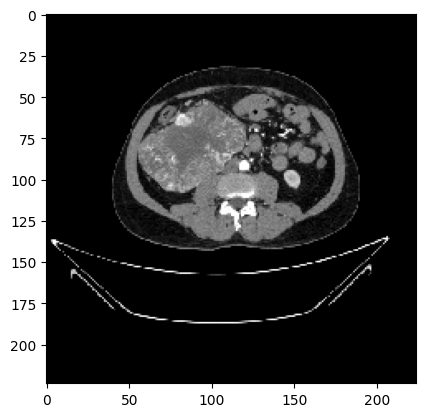

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_34/145765738.py:17: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


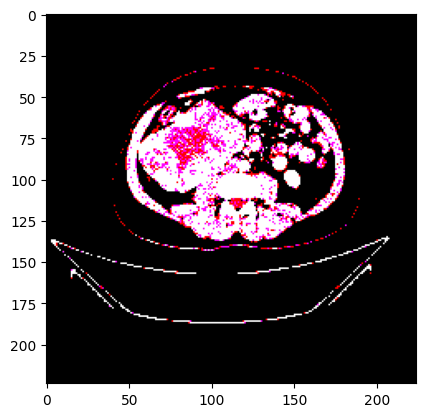

In [12]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()


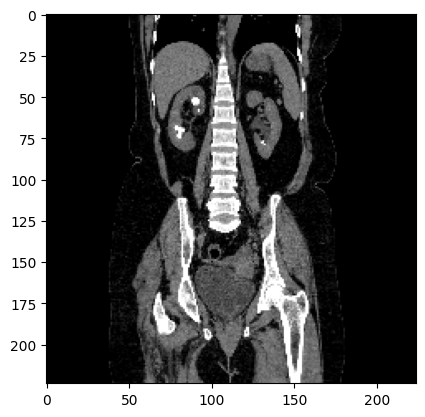

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_34/3946172082.py:17: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


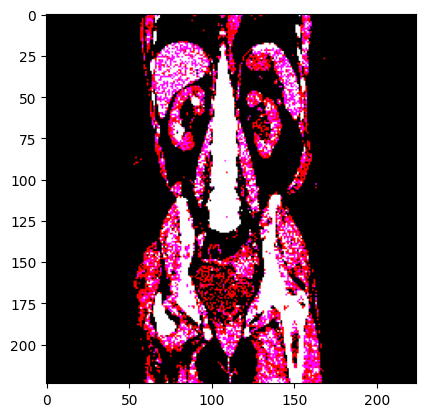

In [13]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()


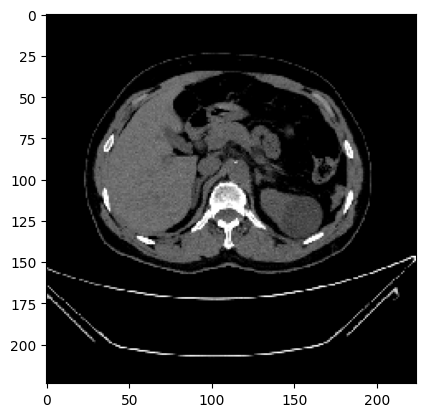

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_34/3558060101.py:17: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


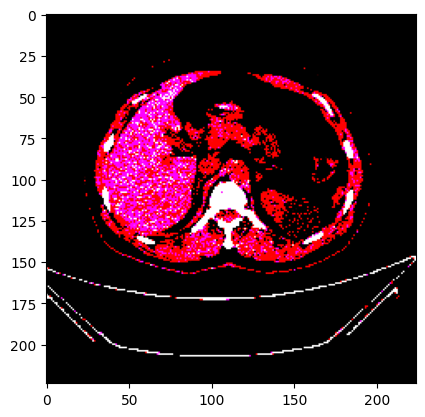

In [14]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()


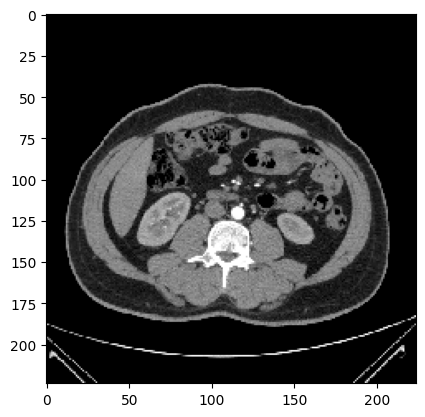

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_34/3953567480.py:17: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


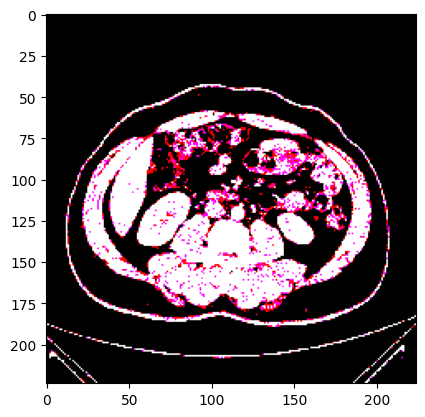

In [15]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
